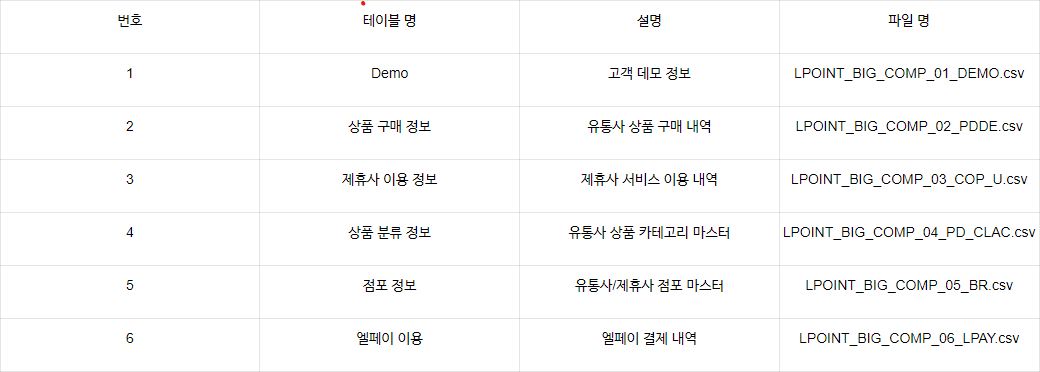

In [3]:
from IPython.display import Image

Image("롯데 빅데이터 공모전 데이터 설명.png")

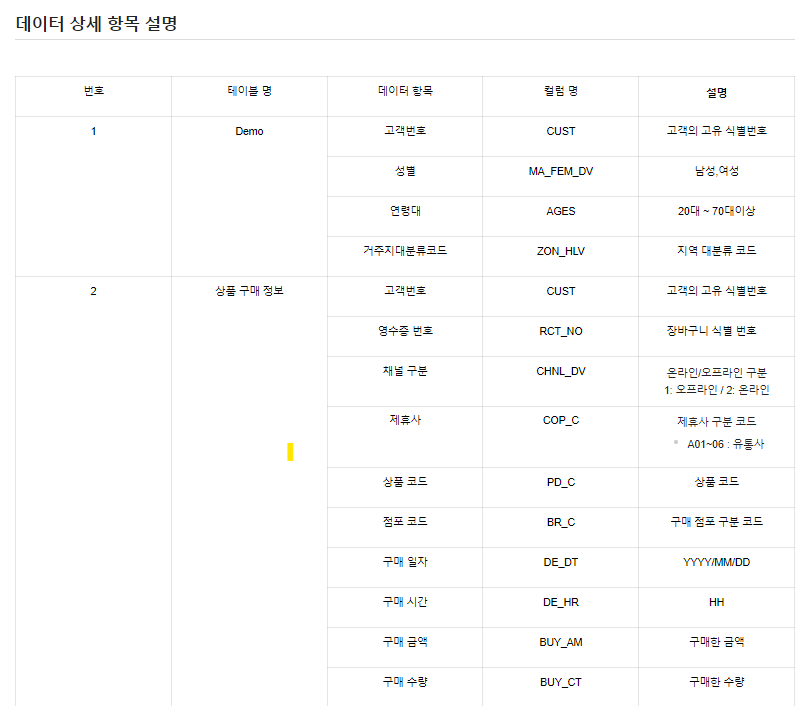

In [4]:
Image("롯데 빅데이터 png.png")

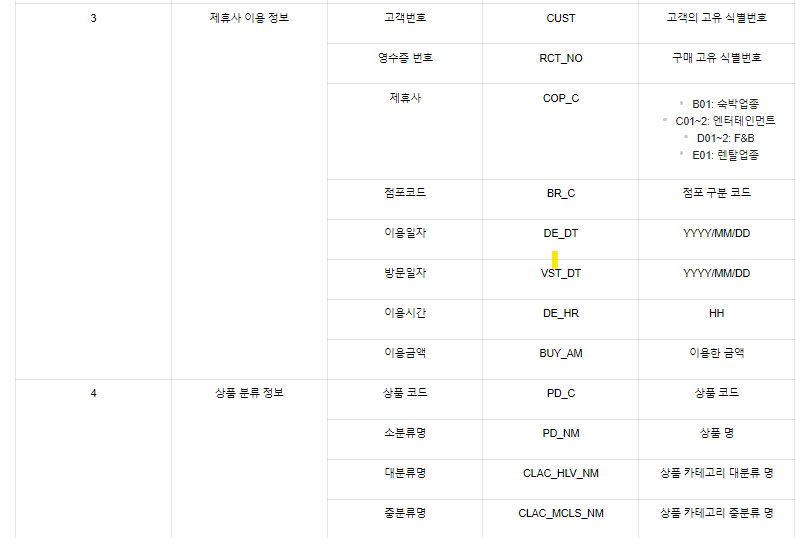

In [5]:
Image("롯데 빅데이터 png2.png")

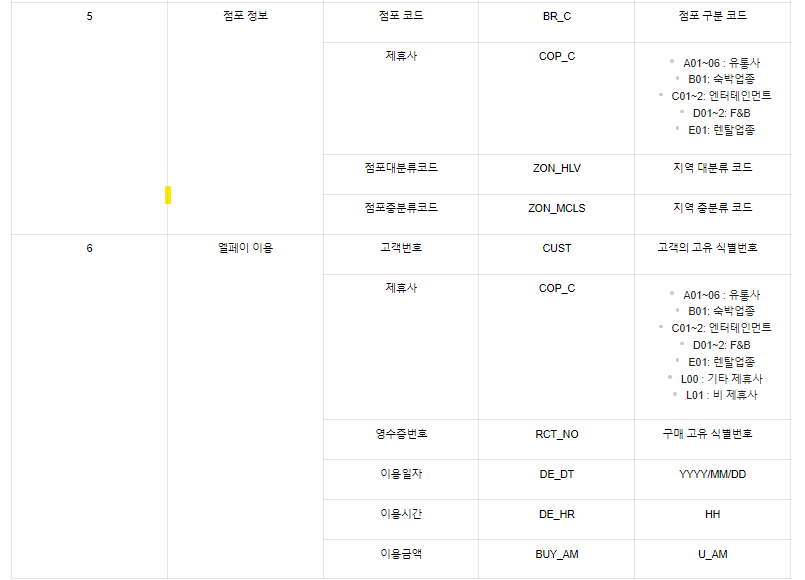

In [6]:
Image("롯데 빅데이터 png3.png")

# 고객 구매 데이터에 기반한 예측 모델 개발 
# 및 개인화 마케팅 전략 제안

In [1]:
import matplotlib.pyplot as plt # pyplot
import matplotlib as mpl # matplotlib
%matplotlib inline
print(mpl.__version__)

import seaborn as sns # seaborn

import pandas as pd
import numpy as np
import pickle
import os, sys
import warnings
warnings.filterwarnings('ignore')
import datetime as dt

pd.set_option('max_columns', 100)
mpl.rc('font', family='New Gulim') # 한글 설정

demo = pd.read_csv('LPOINT_BIG_COMP_01_DEMO.csv')
상품구매 = pd.read_csv('LPOINT_BIG_COMP_02_PDDE.csv')
제휴사 = pd.read_csv('LPOINT_BIG_COMP_03_COP_U.csv')
상품분류 = pd.read_csv('LPOINT_BIG_COMP_04_PD_CLAC.csv')
점포 = pd.read_csv('LPOINT_BIG_COMP_05_BR.csv')
lpay = pd.read_csv('LPOINT_BIG_COMP_06_LPAY.csv')

3.1.3


In [19]:
# 테이블 결합
구매_분류 = pd.merge(상품구매, 상품분류, on='pd_c')
de_구매 = pd.merge(구매_분류, demo, on='cust')
de_lp = pd.merge(demo, lpay, on='cust')



In [20]:
# 상품구매 테이블 날짜(date) 변수 생성 
de_구매 = de_구매.astype({'de_hr':'str', 'de_dt':'str'})

de_구매['date'] = de_구매['de_dt'].apply(lambda x:str(x)[:4] + '-' + str(x)[4:6] + '-' + str(x)[6:])
de_구매['date'] = de_구매['date']+ de_구매['de_hr']
de_구매['date'] = de_구매['date'].apply(lambda x:str(x)[:10] + ' ' + str(x)[10:] + ':00:00' )
de_구매['date'] = pd.to_datetime(de_구매['date'])

de_구매 = de_구매.sort_values(['cust', 'date']).reset_index(drop=True)

# 상품 카테고리 대분류별 총 구매 횟수

Text(0, 0.5, 'count')

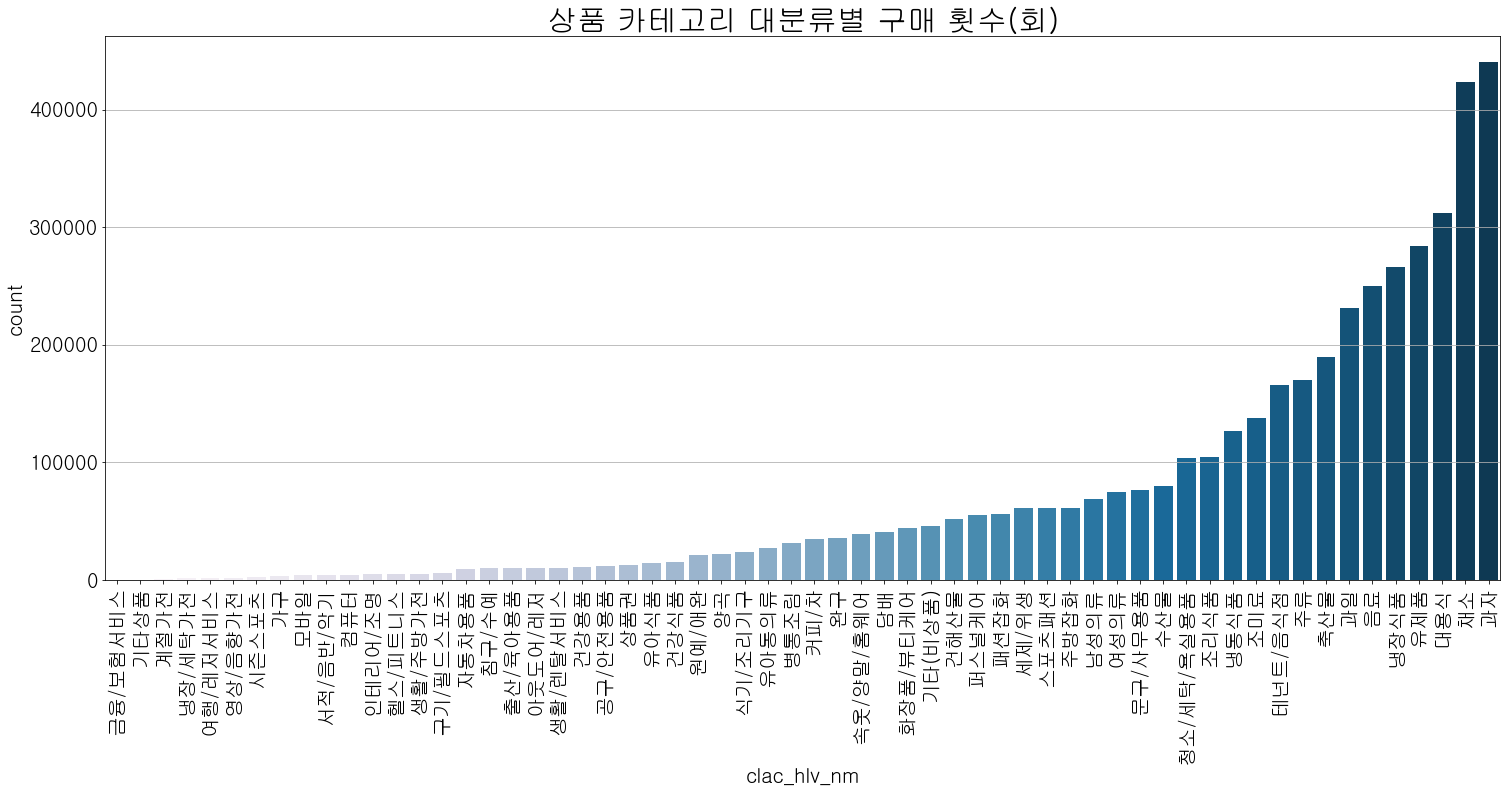

In [21]:
plt.figure(figsize=(25,10))
plt.title('상품 카테고리 대분류별 구매 횟수(회)', fontsize=30)
plt.grid()
sns.countplot(de_구매['clac_hlv_nm'],  order = de_구매['clac_hlv_nm'].value_counts().sort_values().index,  palette="PuBu")
plt.xticks(fontsize=20, rotation=90), plt.yticks(fontsize=20) 
plt.xlabel('clac_hlv_nm', fontsize=20)
plt.ylabel('count', fontsize=20)

In [22]:
# 상품 카테고리 대분류 명(clac_hlv_nm)에서 12개의 카테고리로 재설정 -> 직관적인 판단을 위해 -> 기준: 쿠팡, 다이소 등의 분류 참고
식품= """과자,채소,대용식,유제품,냉장식품,음료,과일,축산물,주류,조미료,
        냉동식품,조리식품,수산물,건해산물,커피/차,병통조림,양곡,건강식품,
        유아식품,담배,테넌트/음식점"""

청소= "청소/세탁/욕실용품,세제/위생" 

문구= "문구/사무용품,완구,공구/안전용품"

의류= "여성의류,남성의류,스포츠패션,패션잡화,속옷/양말/홈웨어,유아동의류"

주방= "주방잡화,식기/조리기구" 

화장품= "퍼스널케어,화장품/뷰티케어"

스포츠= "아웃도어/레저,구기/필드스포츠,헬스/피트니스,시즌스포츠"

취미= "서적/음반/악기,여행/레저서비스,원예/애완"

홈인테리어= "침구/수예,인테리어/조명,가구"

가전_IT= "생활/주방가전,컴퓨터,모바일,영상/음향가전,냉장/세탁가전,계절가전"

문화= "기타(비상품),상품권,생활/렌탈서비스"

생활= "건강용품,자동차용품,출산/육아용품,자동차용품"

# 제외 카테고리는 데이터가 적으므로 추후에 제거 예정
제외= "기타상품,금융/보험서비스"

식품 = 식품.split(",")
청소 = 청소.split(",")
문구 = 문구.split(",")
의류 = 의류.split(",")
주방 = 주방.split(",")
화장품 = 화장품.split(",")
스포츠 = 스포츠.split(",")
취미 = 취미.split(",")
홈인테리어 = 홈인테리어.split(",")
가전_IT = 가전_IT.split(",")
문화 = 문화.split(",")
생활 = 생활.split(",")
제외 = 제외.split(",")


de_구매['category'] = 'X'
categorical = [식품, 청소, 문구, 의류, 주방, 화장품, 스포츠, 취미, 홈인테리어, 가전_IT, 문화, 생활, 제외]
category = ['식품', '청소', '문구', '의류', '주방', '화장품', '스포츠', '취미', '홈인테리어', '가전_IT', '문화', '생활', '제외']


def cate(df):
    for i,j in enumerate(categorical):
        a= category[i]
        for k in j:
            df.loc[ df['clac_hlv_nm'] == k, 'category'] = a

cate(de_구매)

In [17]:
#de_구매.to_csv('de_구매.csv', encoding = 'UTF-8', index = False)

In [24]:
cat_df = pd.DataFrame()

for i in de_구매['category'].unique():
    df = de_구매[de_구매['category'] == i]
    df = df.sort_values(['cust', 'date'], ascending=False).reset_index(drop=True)
    df['category_reorder_day'] = df.groupby(['cust'])['date'].diff()
    cat_df = pd.concat([cat_df, df])
    

cat_df['category_reorder_day'] = cat_df['category_reorder_day'].apply(lambda x: x.days)
cat_df = cat_df.sort_values(['cust', 'date']).reset_index(drop=True)
cat_df['category_reorder_day'] = cat_df['category_reorder_day'].apply(lambda x: abs(x)) 


#cat_df.to_csv('cat_재구매기간.csv', encoding = 'UTF-8', index = False)

In [38]:
#cat_df.loc[(cat_df['category'] == 'X'), 'category'] = '식품'

# 카테고리별 평균 재주문 기간

Text(0, 0.5, '재주문기간')

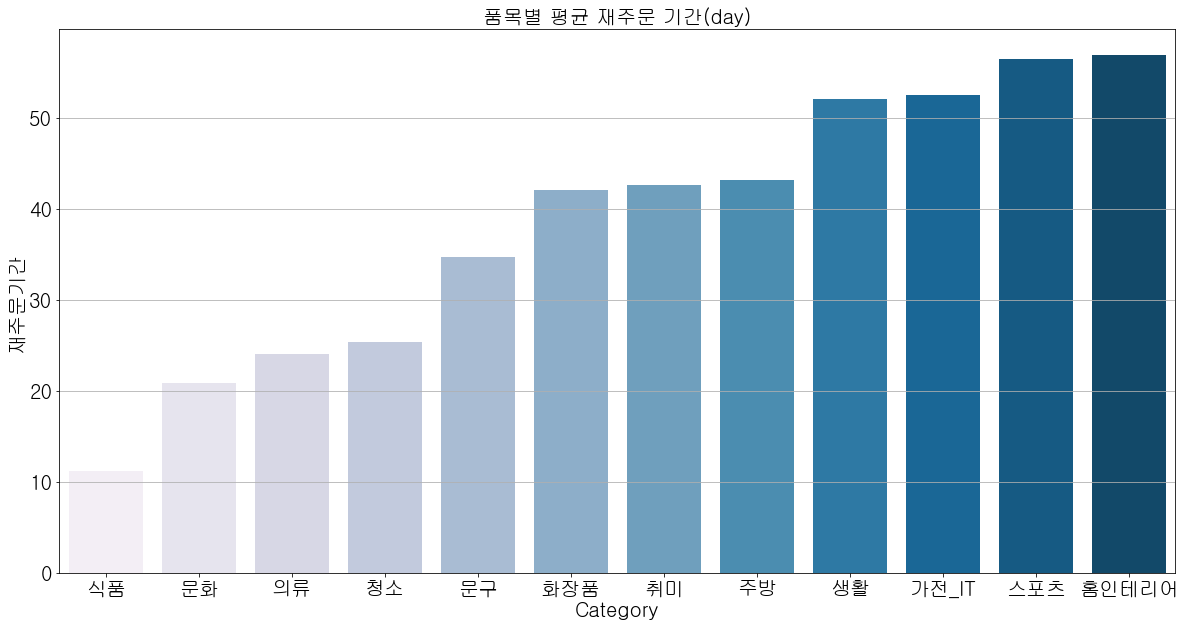

In [59]:
# 재주문 기간이 0보다 큰 데이터를 기준(같은날 주문하면 0으로 기록되기 때문)
Not0_re = cat_df[(cat_df['category'] != '제외' )&(cat_df['category_reorder_day'] > 0)].groupby('category').mean()['category_reorder_day'].reset_index()

plt.figure(figsize=(20,10))
plt.title("품목별 평균 재주문 기간(day)", fontsize=20)
plt.grid()
sns.barplot(Not0_re['category'], Not0_re['category_reorder_day'], palette="PuBu", 
            order=Not0_re.sort_values('category_reorder_day', ascending=True).category)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Category", fontsize=20)
plt.ylabel('재주문기간', fontsize=20)

In [72]:
import numpy as np

# 0제외 (같은날 주문한 물품들 제외)
cat_df = cat_df[cat_df['category_reorder_day'] > 0]

# 카테고리별 재주문 기간 이상치 제거
def cat_outlier(df, cate):
    df2=df[df['category']==cate]
    q25=df2['category_reorder_day'].quantile(.25)
    q75=df2['category_reorder_day'].quantile(.75)
    iqr=q75-q25
    n1=q25-1.5*iqr
    n2=q75+1.5*iqr
    df2['category_reorder_day']=np.where((df2['category_reorder_day']<n1)|(df2['category_reorder_day']>n2),np.nan,df2['category_reorder_day'])
    df2=df2.dropna(subset=['category_reorder_day'])
    return df2


category = ['식품', '청소', '문구', '의류', '주방', '화장품', '스포츠', '취미', '홈인테리어', '가전_IT', '문화', '생활', '제외']
new_df = pd.DataFrame()
for i in category:
    new_df = pd.concat([new_df, cat_outlier(cat_df, i)])


# lpay 이용 여부
lpay['lp_yn'] = 'O'
lpay = lpay[['cust', 'lp_yn']].drop_duplicates(['cust'])

# 상품구매 테이블에서 lpay이용 여부(O,X) 변수 추가
new_df = pd.merge(new_df, lpay[['cust', 'lp_yn']], on='cust', how='left')
new_df = new_df.fillna('X')

In [73]:
# 상품구매 테이블 -> 고객별 누적 주문 횟수 count(order_stack)
new_df = new_df.sort_values(['cust', 'date'])
new_df = new_df.reset_index(drop=True).reset_index()

new_df['order_stack'] = new_df.groupby('cust')['index'].rank(method='first')
new_df = new_df.drop(columns='index')

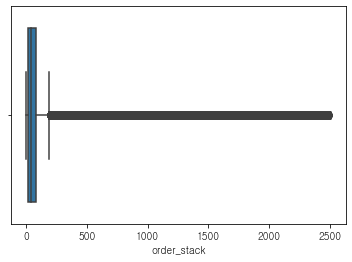

In [88]:
sns.boxplot(new_df['order_stack'])

In [100]:
# 누적 주문 횟수 이상치 제거
def get_outlier(df, column, weight=1.5):
    quantile_25 = np.percentile(df[column].values, 25)
    quantile_75 = np.percentile(df[column].values, 75)
    
    IQR = quantile_75 - quantile_25
    IQR_weight = IQR*weight
    
    lowest = quantile_25 - IQR_weight
    highest = quantile_75 + IQR_weight
    
    return df[(df[column] >= lowest)&(df[column] <= highest)]

final = get_outlier(new_df, column='order_stack', weight=1.5)
final = final.reset_index(drop=True)


In [102]:
import numpy as np

# 고객별 총 주문 횟수 count
final_cnt = final.groupby('cust').count()[['category']].reset_index()[['category']]

# 고객별 총 주문횟수 이상치 제거
def get_outlier(df, column, weight=1.5):
    quantile_25 = np.percentile(df[column].values, 25)
    quantile_75 = np.percentile(df[column].values, 75)
    
    IQR = quantile_75 - quantile_25
    IQR_weight = IQR*weight
    
    lowest = quantile_25 - IQR_weight
    highest = quantile_75 + IQR_weight
    
    return df[(df[column] >= lowest)&(df[column] <= highest)]

get_outlier(final_cnt, column='category', weight=1.5)

,category
0,3
1,40
2,4
3,41
4,29
...,...
23807,3
23808,9
23809,123
23810,20


Text(0, 0.5, '주문 횟수')

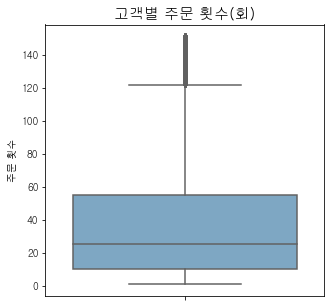

In [103]:
# 고객별 주문 횟수 boxplot
# order_seg(고객 세그먼트)의 기준으로 사용
plt.figure(figsize=(5,5))
plt.title('고객별 주문 횟수(회)', fontsize=15)
sns.boxplot( y ='category' ,orient = "v", palette= 'PuBu', data= get_outlier(final_cnt, column='category', weight=1.5))
plt.ylabel('주문 횟수')

In [104]:
get_outlier(final_cnt, column='category', weight=1.5).describe()

,category
count,22109.000000
mean,37.640735
std,35.886324
min,1.000000
25%,10.000000
50%,25.000000
75%,55.000000
max,151.000000


In [85]:
# boxplot기준 order_seg(고객 세그먼트) 나누기
final['order_seg'] = '주문'

final.loc[final['order_stack'] == 1, 'order_seg'] = '첫주문'
final.loc[(final['order_stack'] >= 2)&(final['order_stack'] < 10), 'order_seg'] = '재주문'
final.loc[(final['order_stack'] >= 10)&(final['order_stack'] < 25), 'order_seg'] = '잠재주문'
final.loc[(final['order_stack'] >= 25), 'order_seg'] = '충성주문'

# 시간대, 계절변수 추가
final['date'] = pd.to_datetime(final['date'])
final['month'] = final['date'].apply(lambda x: x.month)
final['weekday'] = final['date'].apply(lambda x: x.weekday())


final = final.astype({'de_hr':'int'})
final['time'] = 'cf'
final.loc[(final['de_hr']>=0)&(final['de_hr']<=5), 'time'] = '새벽'
final.loc[((final['de_hr']>5)&(final['de_hr']<12)), 'time'] = '아침'
final.loc[((final['de_hr']>=12)&(final['de_hr']<=17)), 'time'] = '점심'
final.loc[(final['de_hr']>=18), 'time' ] = '저녁'

final['season'] = 'cf'
final.loc[(final['month']==12)|(final['month']==1)|(final['month']==2), 'season'] = '겨울'
final.loc[((final['month']>=3)&(final['month']<=5)), 'season'] = '봄'
final.loc[((final['month']>=6)&(final['month']<=8)), 'season'] = '여름'
final.loc[((final['month']>=9)&(final['month']<=11)), 'season'] = '가을'

#final.to_csv('상품구매_final.csv', encoding = 'UTF-8', index = False)

Text(0, 0.5, '재주문기간')

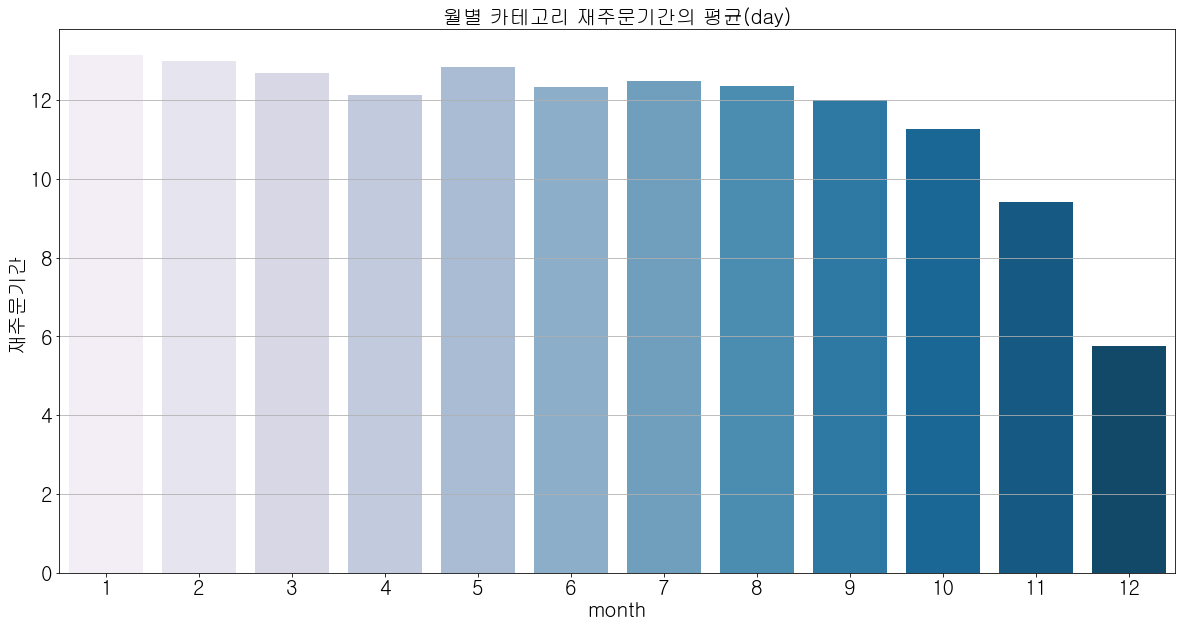

In [218]:
# 월별 카테고리 재주문기간의 평균

plt.figure(figsize=(20,10))
plt.title("월별 카테고리 재주문기간의 평균(day)", fontsize=20)
plt.grid()
sns.barplot(final.groupby('month').mean().reset_index()['month'], 
            final.groupby('month').mean().reset_index()['category_reorder_day'],  palette="PuBu")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("month", fontsize=20)
plt.ylabel('재주문기간', fontsize=20)

Text(0, 0.5, '재주문기간')

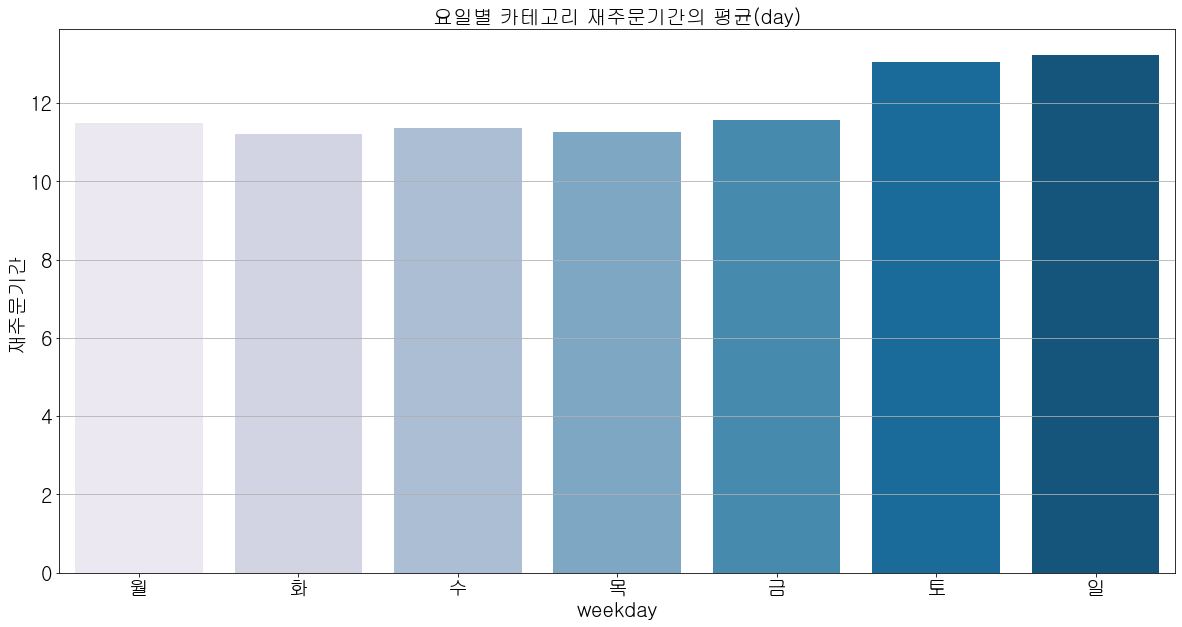

In [221]:
# 요일별 카테고리 재주문기간의 평균

plt.figure(figsize=(20,10))
plt.title("요일별 카테고리 재주문기간의 평균(day)", fontsize=20)
plt.grid()
s = sns.barplot(final.groupby('weekday').mean().reset_index()['weekday'], 
            final.groupby('weekday').mean().reset_index()['category_reorder_day'],  palette="PuBu")

s.set_xticklabels(['월', '화','수','목','금','토','일'])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("weekday", fontsize=20)
plt.ylabel('재주문기간', fontsize=20)

In [2]:
final= pd.read_csv('상품구매_final.csv')

Text(0, 0.5, '재주문기간')

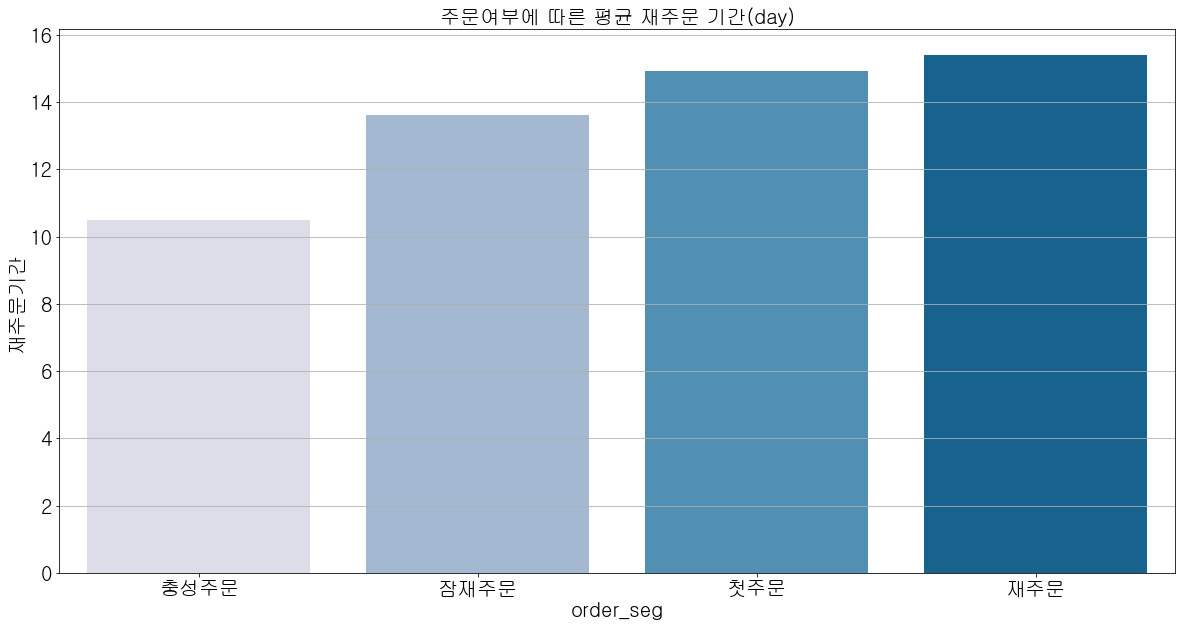

In [11]:
# lpay사용 여부(lp_yn)에 따른 재주문기간의 평균

plt.figure(figsize=(20,10))
plt.title("주문여부에 따른 평균 재주문 기간(day)", fontsize=20)
plt.grid()
sns.barplot(final.groupby('order_seg').mean().reset_index()['order_seg'], 
            final.groupby('order_seg').mean().reset_index()['category_reorder_day'],
            order=final.groupby('order_seg').mean().reset_index().sort_values('category_reorder_day', ascending=True).order_seg,
            palette="PuBu")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("order_seg", fontsize=20)
plt.ylabel('재주문기간', fontsize=20)

Text(0, 0.5, '재주문기간')

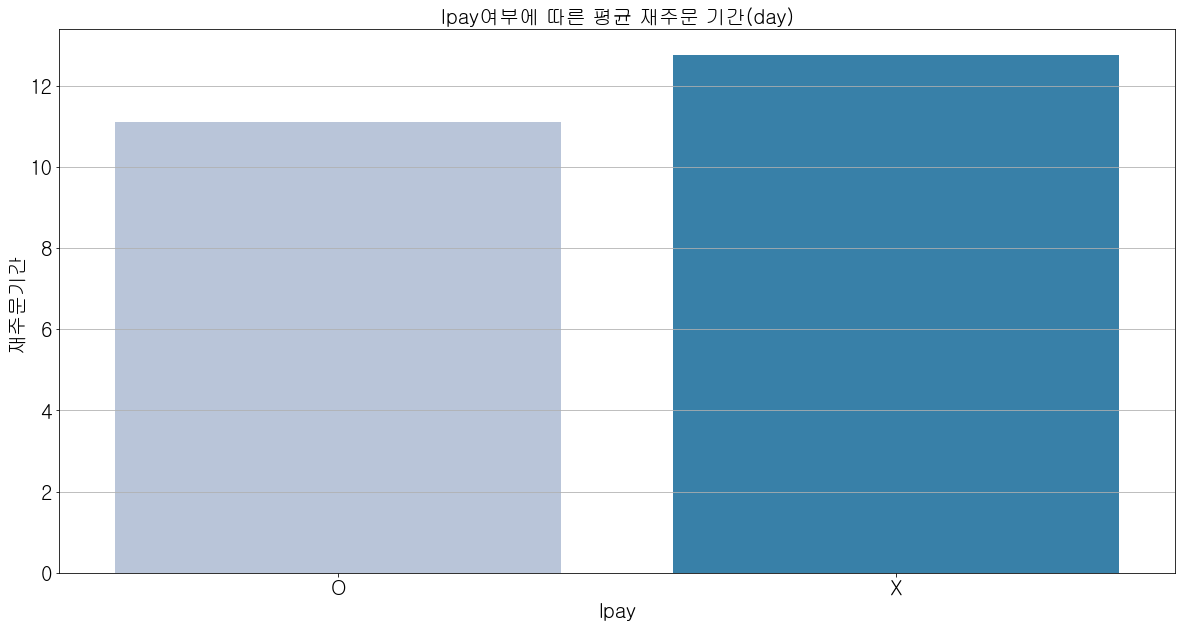

In [87]:
# lpay사용 여부(lp_yn)에 따른 재주문기간의 평균

plt.figure(figsize=(20,10))
plt.title("lpay여부에 따른 평균 재주문 기간(day)", fontsize=20)
plt.grid()
sns.barplot(final.groupby('lp_yn').mean().reset_index()['lp_yn'], 
            final.groupby('lp_yn').mean().reset_index()['category_reorder_day'],  palette="PuBu")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("lpay", fontsize=20)
plt.ylabel('재주문기간', fontsize=20)

Text(0, 0.5, '재주문기간')

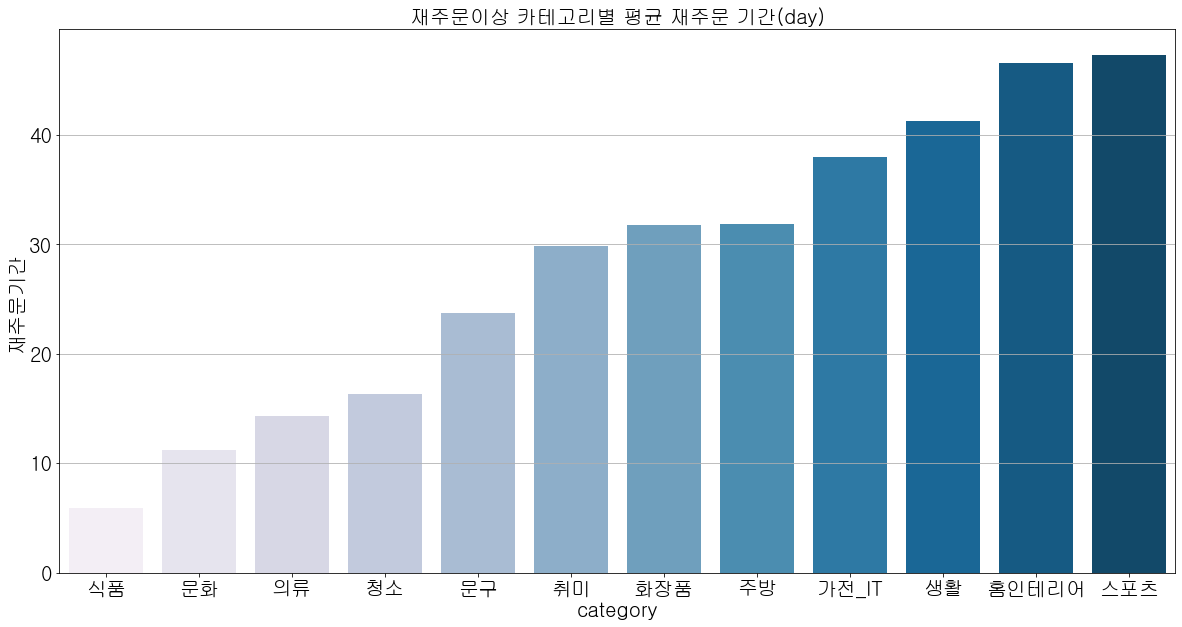

In [13]:
# 첫주문이 아닌 고객의 카테고리별 평균 재주문 기간

re_cat_mean = final[(final['order_seg'] != '첫주문')&(final['category'] != '제외')].groupby('category').mean().reset_index()

plt.figure(figsize=(20,10))
plt.title("재주문이상 카테고리별 평균 재주문 기간(day)", fontsize=20)
plt.grid()
sns.barplot(re_cat_mean['category'], 
            re_cat_mean['category_reorder_day'], 
            order=re_cat_mean.sort_values('category_reorder_day', ascending=True).category,
            palette="PuBu")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("category", fontsize=20)
plt.ylabel('재주문기간', fontsize=20)

Text(0, 0.5, 'count')

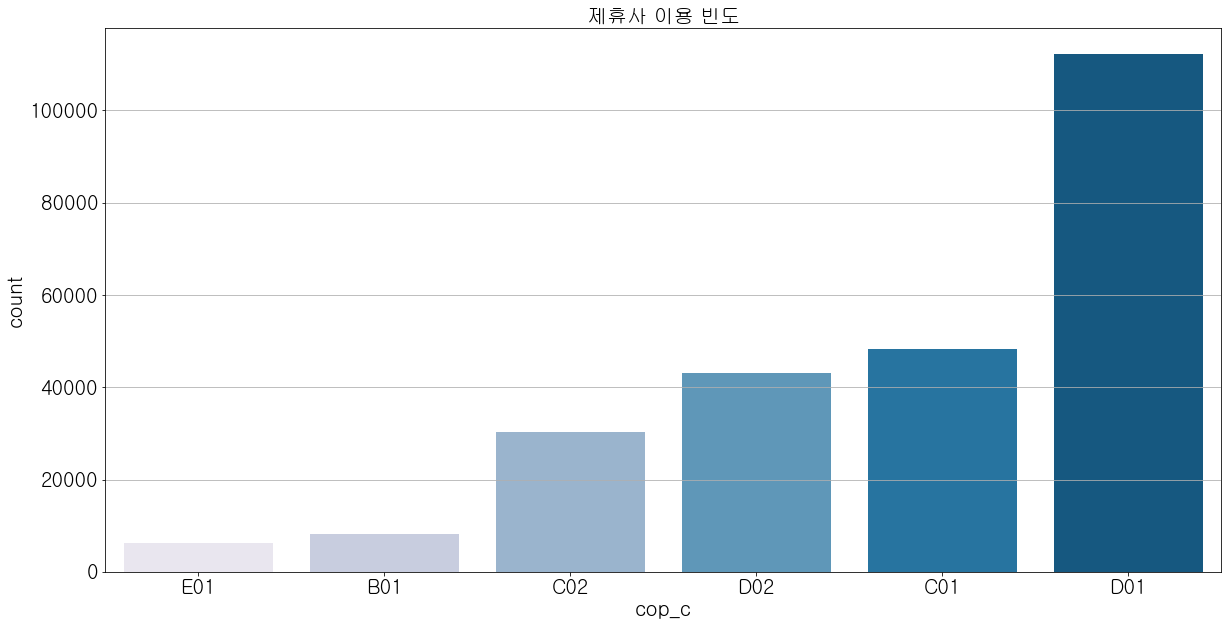

In [20]:
# 제휴사 이용 빈도


plt.figure(figsize=(20,10))
plt.title("제휴사 이용 빈도", fontsize=20)
plt.grid()
sns.barplot(제휴사.groupby('cop_c').count().reset_index()['cop_c'], 
            제휴사.groupby('cop_c').count().reset_index()['cust'], 
            order=제휴사.groupby('cop_c').count().reset_index().sort_values('cust', ascending=True).cop_c,
            palette="PuBu")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("cop_c", fontsize=20)
plt.ylabel('count', fontsize=20)

Text(0, 0.5, 'count')

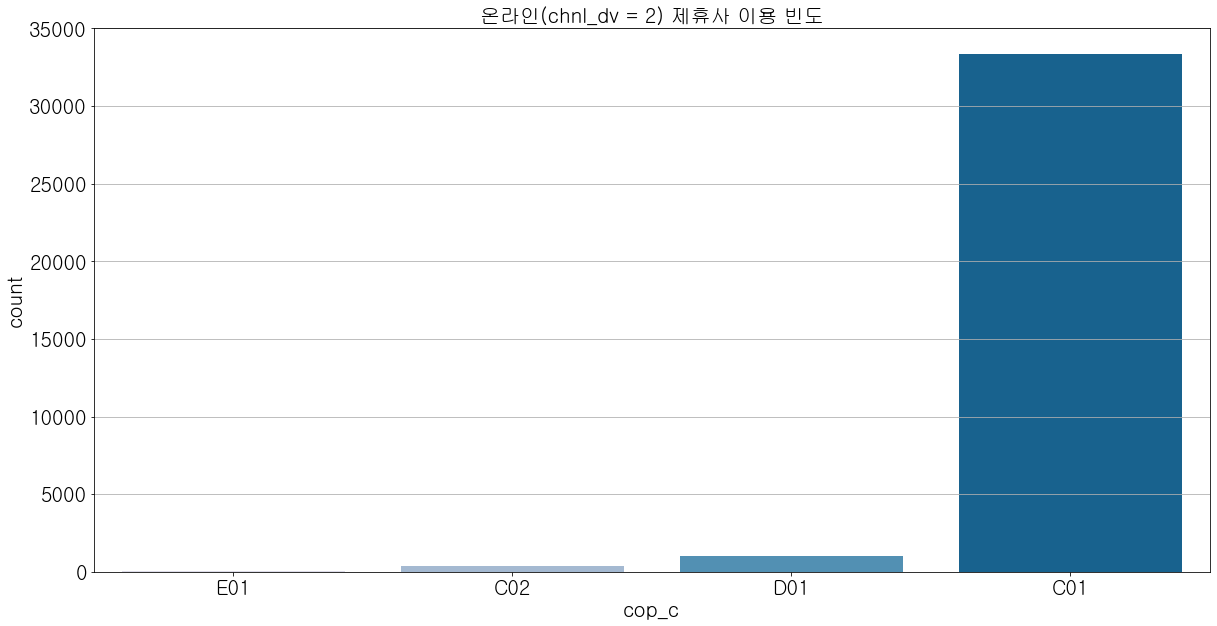

In [23]:
# 온라인 제휴사 이용 빈도


plt.figure(figsize=(20,10))
plt.title("온라인(chnl_dv = 2) 제휴사 이용 빈도", fontsize=20)
plt.grid()
sns.barplot(제휴사[제휴사['chnl_dv'] == 2].groupby('cop_c').count().reset_index()['cop_c'], 
            제휴사[제휴사['chnl_dv'] == 2].groupby('cop_c').count().reset_index()['cust'], 
            order=제휴사[제휴사['chnl_dv'] == 2].groupby('cop_c').count().reset_index().sort_values('cust', ascending=True).cop_c,
            palette="PuBu")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("cop_c", fontsize=20)
plt.ylabel('count', fontsize=20)

Text(0, 0.5, 'count')

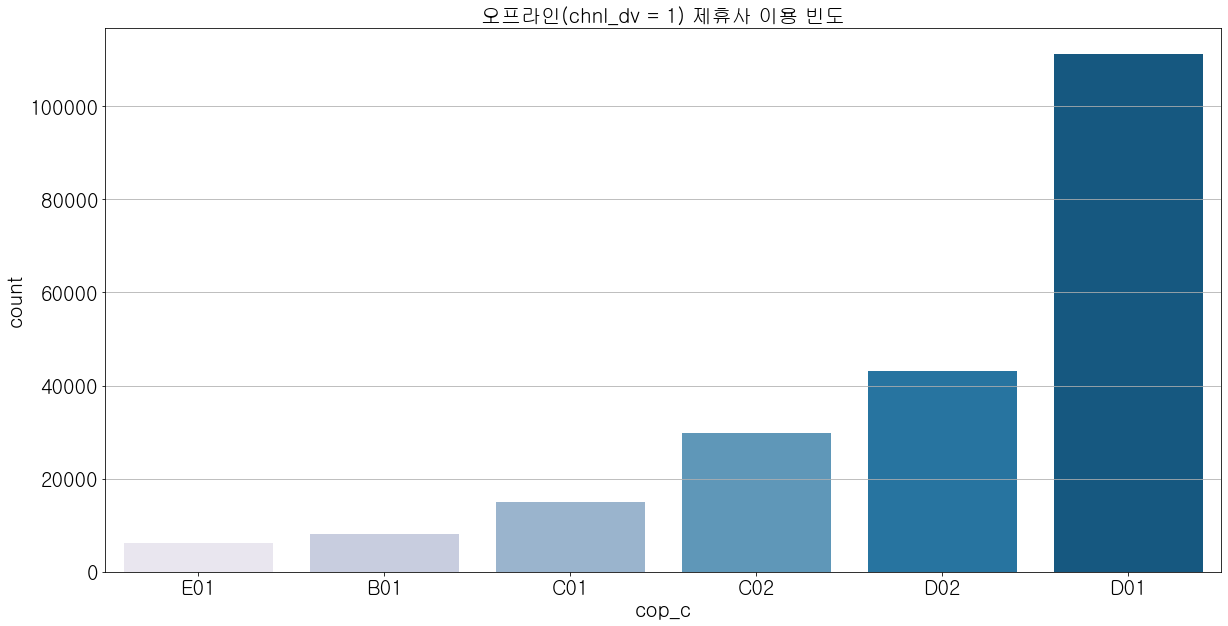

In [24]:
# 오프라인 제휴사 이용 빈도


plt.figure(figsize=(20,10))
plt.title("오프라인(chnl_dv = 1) 제휴사 이용 빈도", fontsize=20)
plt.grid()
sns.barplot(제휴사[제휴사['chnl_dv'] == 1].groupby('cop_c').count().reset_index()['cop_c'], 
            제휴사[제휴사['chnl_dv'] == 1].groupby('cop_c').count().reset_index()['cust'], 
            order=제휴사[제휴사['chnl_dv'] == 1].groupby('cop_c').count().reset_index().sort_values('cust', ascending=True).cop_c,
            palette="PuBu")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("cop_c", fontsize=20)
plt.ylabel('count', fontsize=20)

In [26]:
final.groupby('order_seg').count()

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct,pd_nm,clac_hlv_nm,clac_mcls_nm,ma_fem_dv,ages,zon_hlv,date,category,category_reorder_day,lp_yn,order_stack,month,weekday,time,season
order_seg,,,,,,,,,,,,,,,,,,,,,,,,,
잠재주문,236064,236064,236064,236064,236064,236064,236064,236064,236064,236064,236064,236064,236064,236064,236064,236064,236064,236064,236064,236064,236064,236064,236064,236064,236064
재주문,166278,166278,166278,166278,166278,166278,166278,166278,166278,166278,166278,166278,166278,166278,166278,166278,166278,166278,166278,166278,166278,166278,166278,166278,166278
첫주문,23812,23812,23812,23812,23812,23812,23812,23812,23812,23812,23812,23812,23812,23812,23812,23812,23812,23812,23812,23812,23812,23812,23812,23812,23812
충성주문,711246,711246,711246,711246,711246,711246,711246,711246,711246,711246,711246,711246,711246,711246,711246,711246,711246,711246,711246,711246,711246,711246,711246,711246,711246


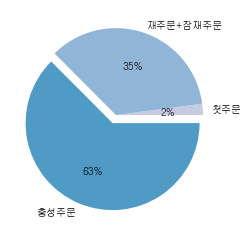

In [60]:
colors = sns.color_palette('pastel')[0:5]

data = [23812, 402342, 711246]
labels =  ['첫주문', '재주문+잠재주문', '충성주문']

explode = [0,0,0.1]
colors = sns.color_palette('PuBu')[1:]

plt.pie(data, labels=labels, colors=colors,
        explode=explode, autopct='%.0f%%')
plt.show()

Text(0, 0.5, '재주문기간')

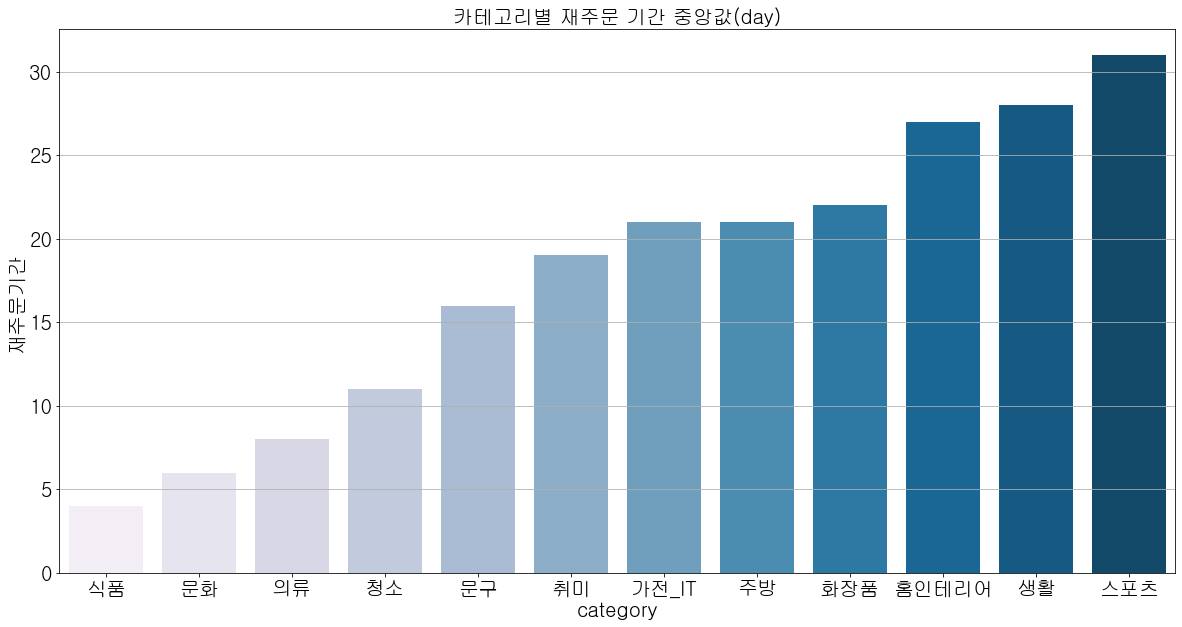

In [67]:
# 카테고리별 재주문 기간 중앙값(첫주문 이탈예상고객 마케팅을 위한)

first_cat_median = final[(final['category'] != '제외')].groupby('category').median().reset_index()[['category', 'category_reorder_day']]

plt.figure(figsize=(20,10))
plt.title("카테고리별 재주문 기간 중앙값(day)", fontsize=20)
plt.grid()
sns.barplot(first_cat_median['category'], 
            first_cat_median['category_reorder_day'], 
            order=first_cat_median.sort_values('category_reorder_day', ascending=True).category,
            palette="PuBu")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("category", fontsize=20)
plt.ylabel('재주문기간', fontsize=20)

Text(0, 0.5, 'count')

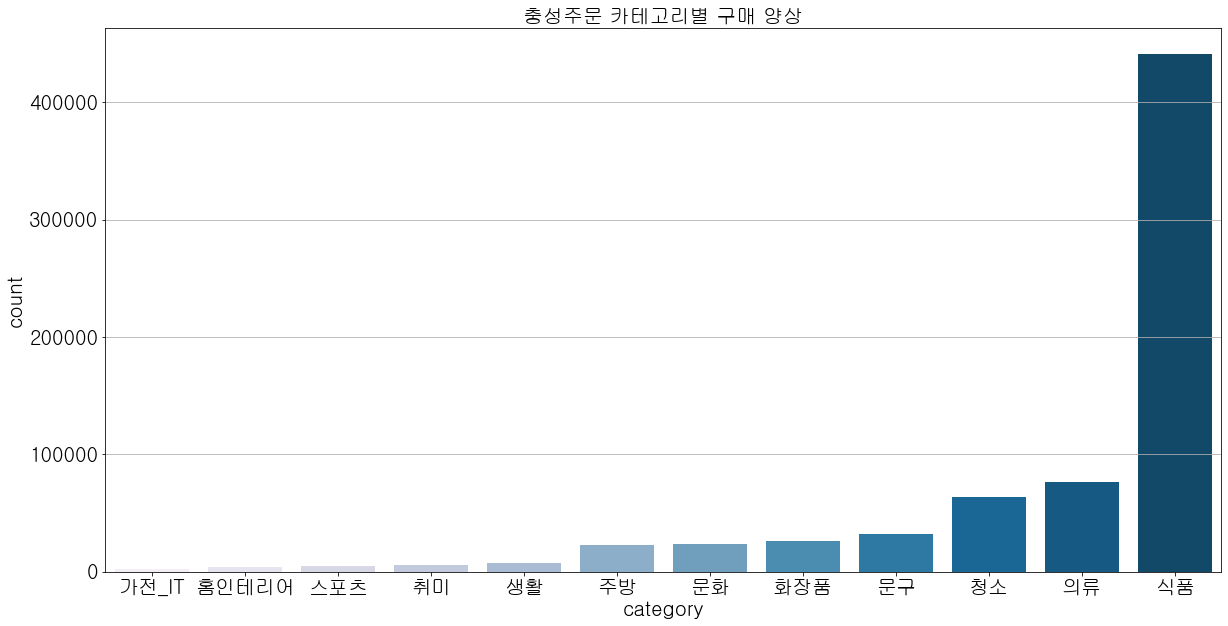

In [73]:
# 충성주문 카테고리 구매 양상

re_cat = final[(final['order_seg'] == '충성주문')&(final['category'] != '제외')].groupby('category').count().reset_index()

plt.figure(figsize=(20,10))
plt.title("충성주문 카테고리별 구매 양상", fontsize=20)
plt.grid()
sns.barplot(re_cat['category'], 
            re_cat['cust'], 
            order=re_cat.sort_values('cust', ascending=True).category,
            palette="PuBu")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("category", fontsize=20)
plt.ylabel('count', fontsize=20)

# 시간대별 온/오프라인 구매 비율

In [145]:
import numpy as np
import matplotlib.pyplot as plt

N = 24
ind = np.arange(N)

a = final.groupby(['chnl_dv', 'de_hr']).count().reset_index().iloc[:, 1:3].iloc[:24, ].reset_index(drop=True)
b = final.groupby(['chnl_dv', 'de_hr']).count().reset_index().iloc[:, 1:3].iloc[24:, ].reset_index(drop=True)[['cust']]
b = b.rename(columns={'cust': 'cust2'})
ab = pd.concat([a,b], axis=1)
ab['cust_per'] =  (ab['cust']/(ab['cust'] + ab['cust2'])) * 100
ab['cust2_per'] = 100 - ab['cust_per']

upper =ab['cust_per'].values
bottom = ab['cust2_per'].values

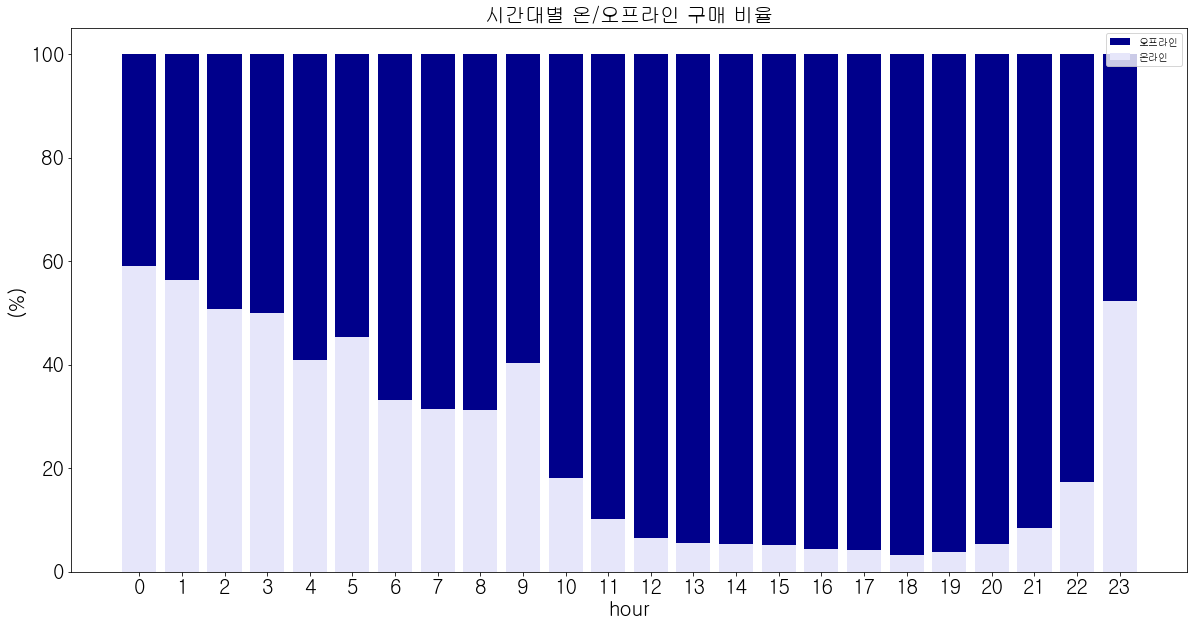

In [216]:

plt.figure(figsize=(20,10))
plt.title('시간대별 온/오프라인 구매 비율', fontsize=20)
p1 = plt.bar(ind, bottom, color='lavender')
p2 = plt.bar(ind, upper, color='darkblue',
             bottom=bottom)

plt.legend((p2[0], p1[0]), ('오프라인', '온라인'))
plt.xticks(ind,fontsize=20), plt.yticks(fontsize=20)
plt.xlabel('hour',fontsize=20), plt.ylabel('(%)', fontsize=20)
plt.show()

# 카테고리 요일별 평균 구매금액

In [160]:
week_cat_buy = final[final['category'] != '제외'].groupby(['weekday', 'category']).mean().reset_index()[['weekday', 'category', 'buy_am']]

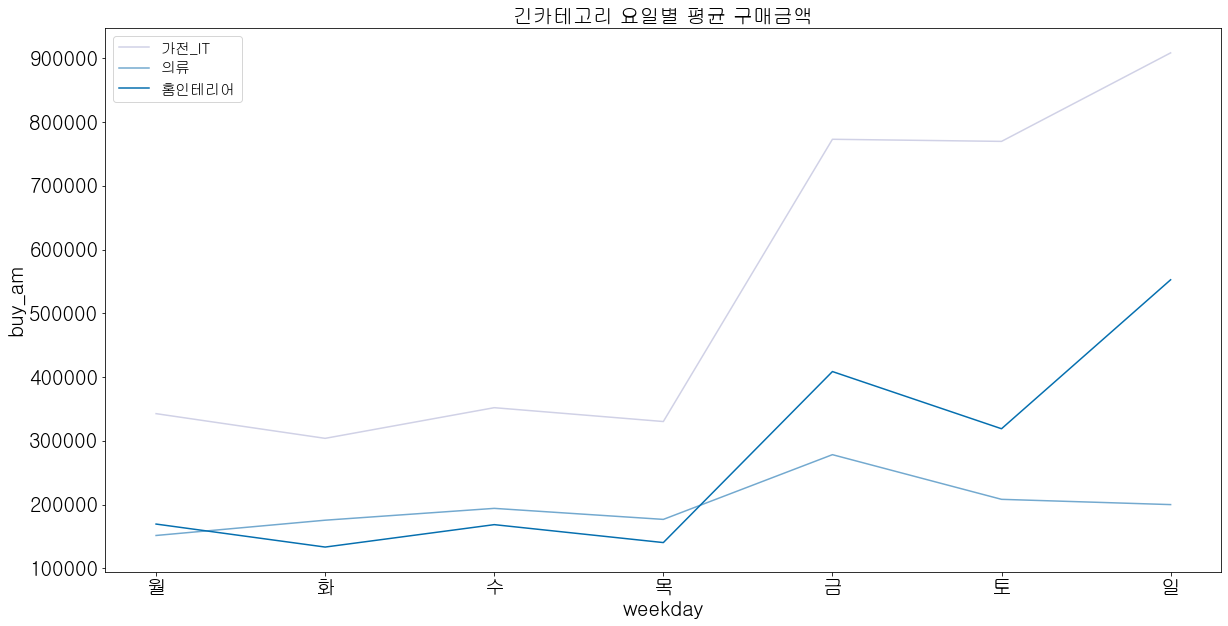

In [214]:
plt.figure(figsize=(20,10))
plt.title('긴카테고리 요일별 평균 구매금액', fontsize=20)
g = sns.lineplot(x="weekday", y="buy_am",
            hue="category",  palette='PuBu',
             data=week_cat_buy[(week_cat_buy['category'] == '가전_IT')|(week_cat_buy['category'] == '홈인테리어')|(week_cat_buy['category'] == '의류')])
g.set_xticklabels(['none','월', '화','수','목','금','토','일'])
plt.xticks(fontsize=20), plt.yticks(fontsize=20)
plt.xlabel('weekday', fontsize=20), plt.ylabel('buy_am', fontsize=20)
plt.legend(fontsize=15)

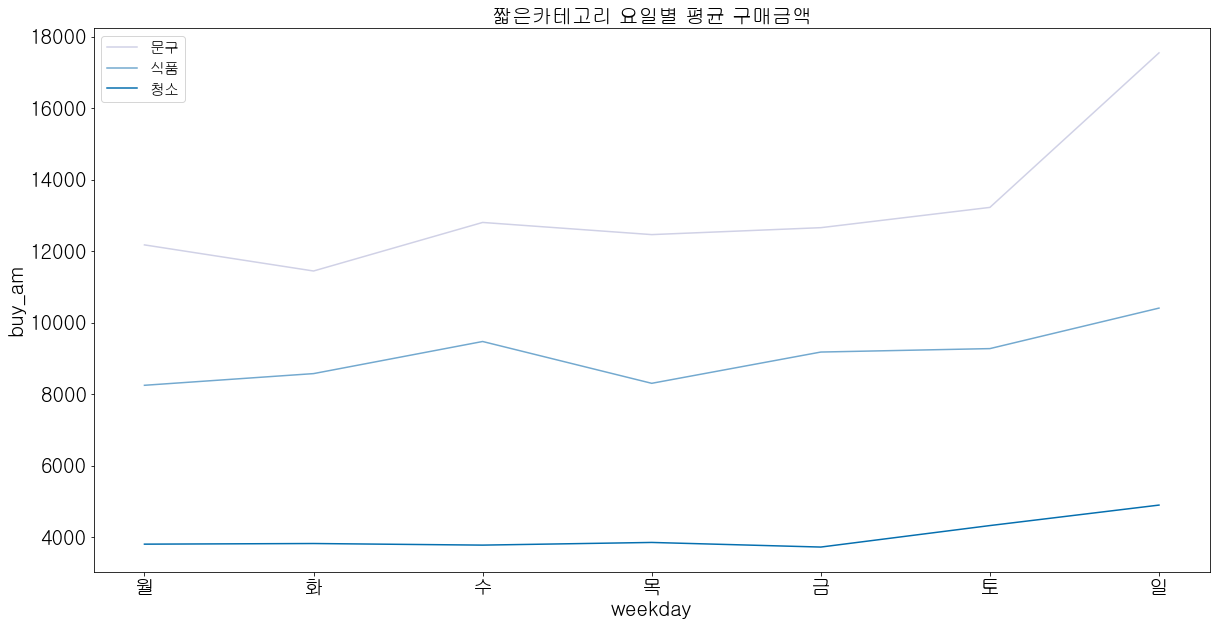

In [215]:
plt.figure(figsize=(20,10))
plt.title('짧은카테고리 요일별 평균 구매금액', fontsize=20)
g = sns.lineplot(x="weekday", y="buy_am",
            hue="category",  palette='PuBu',
             data=week_cat_buy[(week_cat_buy['category'] == '청소')|(week_cat_buy['category'] == '식품')|(week_cat_buy['category'] == '문구')])
g.set_xticklabels(['none','월', '화','수','목','금','토','일'])
plt.xticks(fontsize=20), plt.yticks(fontsize=20)
plt.xlabel('weekday', fontsize=20), plt.ylabel('buy_am', fontsize=20)
plt.legend(fontsize=15)

# 첫주문, 재주문이상에 대한 카테고리별 주문비율

In [10]:
# 식품은 주문비율이 워낙높아서 제외하고 시각화
첫주문_cat = final[(final['order_seg'] == '첫주문')&(final['category'] != '식품')].groupby('category').count().reset_index().iloc[:,:2]
첫주문_cat['per'] = 첫주문_cat['cust'] / 8985 * 100

재주문_cat = final[(final['order_seg'] != '첫주문')&(final['category'] != '식품')].groupby('category').count().reset_index().iloc[:,:2]
재주문_cat['per'] = 재주문_cat['cust'] / 462067 * 100

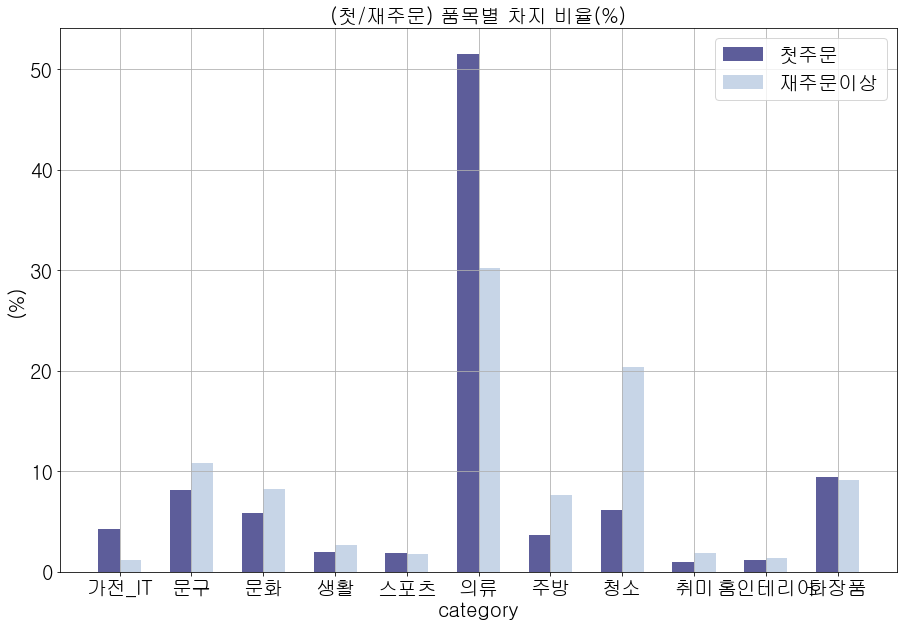

In [25]:
# 오프라인,성별에 따른 재주문까지 소요된 기간 

label = 첫주문_cat['category'].unique()
f_re = 첫주문_cat['per'].values
t_re = 재주문_cat[재주문_cat['category'] != '제외']['per'].values
index = np.arange(len(label))
bar_width=0.3
alpha=0.7


plt.figure(figsize=(15,10))
plt.grid()
plt.title('(첫/재주문) 품목별 차지 비율(%)', fontsize=20)
plt.bar(index- 0.15, f_re, bar_width, color='midnightblue', alpha = alpha,label='첫주문')
plt.bar(index + 0.15, t_re, bar_width, color='lightsteelblue', alpha = alpha,label='재주문이상')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
               ['가전_IT', '문구', '문화', '생활', '스포츠', '의류',
               '주방', '청소', '취미', '홈인테리어', '화장품'], fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('category', fontsize=20)
plt.ylabel('(%)', fontsize=20)
plt.legend(fontsize=20)

In [34]:
# 이탈범위선정 예측 기간이 mean(category_reorder_day) + Z-score*sigma(root(n)) 을 넘어가면 이탈가능성이 있는 고객으로 선정
#-> 신뢰구간 공식 활용


def confidence_interval(df, order_seg):
    std = df[df['order_seg'] == order_seg].groupby('category').std()[['category_reorder_day']].reset_index()
    mean = df[df['order_seg'] == order_seg].groupby('category').mean()[['category_reorder_day']].reset_index()
    cnt = df[df['order_seg'] == order_seg].groupby('category').count().reset_index()[['cust']]
    
    mean['lower_ci'] = mean['category_reorder_day'] - 1.96*(std['category_reorder_day'] / np.sqrt(cnt['cust']) )
    mean['higher_ci'] = mean['category_reorder_day'] + 1.96*(std['category_reorder_day'] / np.sqrt(cnt['cust']) )

    return mean


첫주문 = pd.merge(final[final['order_seg'] == '첫주문'], 
               confidence_interval(final, '첫주문')[['category', 'lower_ci', 'higher_ci']], on='category')
잠재주문 = pd.merge(final[final['order_seg'] != '첫주문'], 
                confidence_interval(final, '잠재주문')[['category', 'lower_ci', 'higher_ci']], on='category')

final = pd.concat([첫주문, 잠재주문])
final = final.reset_index()


final['churn'] = 'X'

final.loc[final['category_reorder_day'] > final['higher_ci'], 'churn'] = 'O'

In [20]:
# 전체 고객의 이탈율
final.groupby('churn').count()

373896 / (373896 + 763503) * 100

32.872896846225466

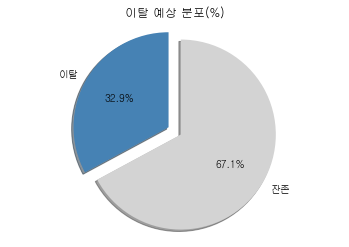

In [229]:
example_series = pd.Series([373896,763503], index = ['이탈', '잔존'])
colors = pd.Series(['steelblue', 'lightgray'], index = example_series.index)
explode = pd.Series([0.05, 0.1], index = example_series.index)

title = '이탈 예상 분포(%)'
fig, ax = plt.subplots()
ax.pie(example_series, labels = example_series.index, autopct = '%.1f%%', colors = colors, explode = explode,
      shadow = True, startangle = 90)
ax.axis('equal')
ax.set_title(title)
plt.show()




In [39]:
#final = final.drop(columns='index')

# 모델링

In [46]:
model_final = final.drop(columns= ['weekday', 'cust', 'de_hr', 'rct_no', 'cop_c', 'br_c', 'pd_c', 'de_dt', 'date', 'pd_nm'
                                            , 'clac_hlv_nm', 'clac_mcls_nm', 'zon_hlv','chnl_dv', 'weekday', 'order_stack', 
                                   'month', 'lower_ci', 'higher_ci'])

model_final = model_final.reset_index(drop=True)
model_final = pd.get_dummies(model_final, drop_first=True)

# train/test 분리
train = model_final.copy()
test = model_final.sample(frac=0.3, replace=False, random_state= 7)
test.drop(columns=['category_reorder_day'])

,buy_am,buy_ct,ma_fem_dv_여성,ages_30대,ages_40대,ages_50대,ages_60대,ages_70대,category_문구,category_문화,category_생활,category_스포츠,category_식품,category_의류,category_주방,category_청소,category_취미,category_홈인테리어,category_화장품,lp_yn_X,order_seg_재주문,order_seg_첫주문,order_seg_충성주문,time_아침,time_저녁,time_점심,season_겨울,season_봄,season_여름,churn_X
284766,5940.0,3,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0
1034623,500.0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1
463294,279000.0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
304102,6990.0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1
1104802,2000.0,2,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1073812,2000.0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1
44669,59000.0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0
826376,2520.0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1
1120412,3000.0,3,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1


- RandomForestRegressor

In [47]:
from sklearn.ensemble import RandomForestRegressor

# 모델 선언
model = RandomForestRegressor()

# 학습에 사용할 정보와 예측하고자 하는 정보를 분리합니다.
x_train = train.drop(columns=['category_reorder_day'])
y_train = train['category_reorder_day']


x_test = test.drop(columns=['category_reorder_day'])
y_test = test['category_reorder_day']


# 모델 학습
model.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [48]:
# 학습된 모델을 이용해 결과값 예측후 상위 10개의 값 확인
prediction = model.predict(x_test)
print('----------------------예측된 데이터의 상위 10개의 값 확인--------------------\n')
print(prediction[:10])

----------------------예측된 데이터의 상위 10개의 값 확인--------------------

[12.74042857  3.65906349 18.15        2.72491672 56.97763095  8.53045413
 26.52492857  2.34364274 35.64        2.36743785]


In [49]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, prediction)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, prediction)
print("MSE:", mse)
print("RMSE:", rmse)
print("R square:", r2)

MSE: 22.359682871531025
RMSE: 4.728602634133156
R square: 0.9297652298956967


- XGBRegressor

In [53]:
import xgboost
xgb_model = xgboost.XGBRegressor()

xgb_model.fit(x_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [54]:
from sklearn.metrics import explained_variance_score

prediction = xgb_model.predict(x_test)
mse = mean_squared_error(y_test, prediction)
rmse = np.sqrt(mse)


print("MSE:", mse)
print("RMSE:",rmse)
print("R2 score:",r2_score(y_test,prediction))

MSE: 63.328329415536686
RMSE: 7.9579098647532245
R2 score: 0.8010772029663739


- LGBMRegressor

In [56]:
import lightgbm as lgb

lgb_model = lgb.LGBMRegressor()

lgb_model.fit(x_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [58]:
from sklearn.metrics import explained_variance_score

prediction = lgb_model.predict(x_test)
mse = mean_squared_error(y_test, prediction)
rmse = np.sqrt(mse)


print("MSE:", mse)
print("RMSE:",rmse)
print("R2 score:",r2_score(y_test,prediction))

MSE: 64.1476076001401
RMSE: 8.009220161797284
R2 score: 0.7985037400385809
